In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from pytorch_pretrained_vit import ViT
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn

In [24]:
#hyper params
lr = 1e-5
wd = 1e-1
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 40
classes = [10,11,14,16,6,7] #arranged in order of their placement in the folder
num_classes = len(classes)
path = 'only_relevant_dataset'
hardness_threshold = 0.75
lambda_u = 0.1  # Weighting factor for the unsupervised loss


In [3]:

def get_dataset(path,val_split,test_split):
    transform_weak = transforms.Compose([transforms.Resize((256,256)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                               ])

    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset_strong = datasets.ImageFolder(path,transform=transform_strong)
    dataset_weak = datasets.ImageFolder(path,transform=transform_weak)

    trainset_strong,valset_strong,testset_strong = stratified(dataset_strong)
    trainset_weak,valset_weak,testset_weak = stratified(dataset_weak)
    
    print("train strong:",len(trainset_strong),"val strong:",len(valset_strong),"test strong:",len(testset_strong))
    print("train weak:",len(trainset_weak),"val weak:",len(valset_weak),"test strong:",len(testset_weak))

    
    return trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak

In [4]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [5]:
def train_model(trainset_strong, valset_strong, trainset_weak,valset_weak, model, criterion, optimizer, scheduler, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset_strong, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_strong, batch_size=bs, shuffle=True)
    }

    dataloaders_weak = {
        'train': data.DataLoader(trainset_weak, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_weak, batch_size=bs, shuffle=True)
    }
    dataset_sizes_strong = {'train': len(trainset_strong), 'val': len(valset_strong)}
    dataset_sizes_weak = {'train': len(trainset_weak), 'val': len(valset_weak)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for (inputs_strong, _), (inputs_weak, labels_weak) in zip(dataloaders_strong[phase],dataloaders_weak[phase]):
                inputs_strong = inputs_strong.to(device)
                inputs_weak = inputs_weak.to(device)                
                labels_weak = labels_weak.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_weak = model(inputs_weak)
                    _, preds_weak = torch.max(outputs_weak, 1)

                    #loss = criterion(outputs_weak, labels_weak)



                    # Calculate hardness score for each sample in the batch
                    probabilities_hard = torch.softmax(outputs_weak, dim=1)
                    hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                    # Skip predictions if hardness score is greater than the threshold
                    skip_mask = hardness_scores <= hardness_threshold
                    
                    
                    if skip_mask.sum().item() > 0:
                        c += 1
                        inputs_weak = inputs_weak[skip_mask]
                        labels_weak = labels_weak[skip_mask]
                        preds_weak = preds_weak[skip_mask]
                        #loss = criterion(outputs_weak[skip_mask], labels_weak)
                    
                    #skip_mask = skip_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3).expand_as(inputs)  # Expand mask dimensions

                    # AdaMatch steps
                    outputs_strong = model(inputs_strong)
                    pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
                    max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
                    mask = max_probs.ge(0.95).float()

                    unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()
                    loss = lambda_u * unsupervised_loss

                    outputs_strong = pseudo_labels.clone().detach()
                    inputs = torch.cat([inputs_weak, inputs_strong])
                    labels = torch.cat([labels_weak, outputs_strong])

                    supervised_outputs = model(inputs)
                    _, supervised_preds = torch.max(supervised_outputs, 1)
                    supervised_loss = criterion(supervised_outputs, labels)
                    loss += supervised_loss

                    # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                    unique_classes_pred = np.unique(supervised_preds.cpu().numpy())
                    unique_classes_true = np.unique(labels.cpu().numpy())

                    if np.all(np.in1d(unique_classes_pred, unique_classes_true)):
                        balanced_acc = balanced_accuracy_score(labels.cpu(), supervised_preds.cpu())
                    else:
                        balanced_acc = 0.0  # Assign 0 if classes in y_pred not present in y_true

                    all_labels.extend(labels.cpu().tolist())
                    all_preds.extend(supervised_preds.cpu().tolist())
                    
                    # Backpropagation and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(supervised_preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(supervised_outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
            epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
            epoch_entropy /= (dataset_sizes_strong[phase]+dataset_sizes_weak[phase]) # Calculate average epoch entropy

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_train.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_val.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation

            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print('Number of skipped:', c)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val
    )
  

In [6]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

              
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / len(testset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [7]:

def weighted_score_array(model,models,dataset_strong, dataset_weak):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader_strong = data.DataLoader(dataset_strong,batch_size=bs,shuffle=True)
    dataloader_weak = data.DataLoader(dataset_weak,batch_size=bs,shuffle=True)
    
    for (inputs_strong, _), (inputs_weak, labels_weak) in zip(dataloader_strong,dataloader_weak):
        inputs_strong = inputs_strong.to(device)
        inputs_weak = inputs_weak.to(device)                
        labels_weak = labels_weak.to(device)
        
        predictions = set()
        with torch.set_grad_enabled(False):
             # AdaMatch steps
            outputs_strong = model(inputs_strong)
            pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
            max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
            mask = max_probs.ge(0.95).float()

            unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()

            outputs_strong = pseudo_labels.clone().detach()
            inputs = torch.cat([inputs_weak, inputs_strong])
            labels = torch.cat([labels_weak, outputs_strong])

            supervised_outputs = models[0](inputs)
            _, supervised_preds = torch.max(supervised_outputs, 1)
            predictions.add(supervised_preds)  
            
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                supervised_outputs = torch.cat((supervised_outputs,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,supervised_outputs.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,supervised_outputs.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        """ Resnet50
        """
        print("Resnet50")
        model_ft = models.resnet50(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(2048,num_classes)
        #num_ftrs = model_ft.fc.in_features
        #model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "mobilenet":
        """ Mobilenet_V2
        """
        print("Mobilenet_V2")
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            )
            #nu        #num_features = model.classifier[1].in_features
        #model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg":
        """ VGG16_bn
        """
        print("VGG16_bn")
        model_ft = models.vgg16(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)
        #num_ftrs = model_ft.classifier[6].in_features
        #model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "googlenet":
        """ googlenet
        """
        print("VGG16_bn")
        model_ft = torchvision.models.googlenet(weights='DEFAULT')
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(1024,num_classes)
        #model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        #model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        print("Densenet")
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier = nn.Linear(2208,num_classes)
        #num_ftrs = model_ft.classifier.in_features
        #model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "vit":
        """ Vision Transformer (ViT) """
        print("ViT")
        model_ft = ViT('B_16_imagenet1k', pretrained=True)


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run

# Print the model we just instantiated
#print(model_ft)


In [10]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [11]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [18]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak = get_dataset(path, val_size, test_size)

train strong: 9628 val strong: 2408 test strong: 2124
train weak: 9628 val weak: 2408 test strong: 2124


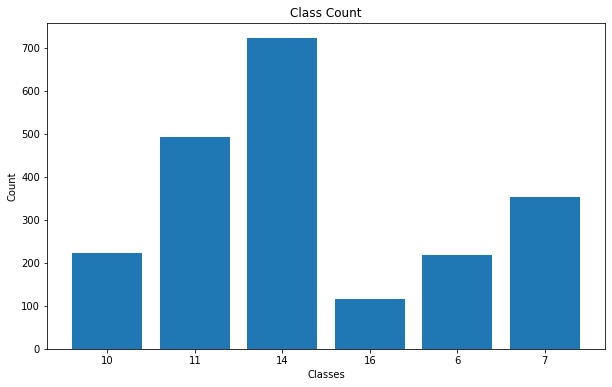

In [32]:
plot_distribution_by_class(testset_strong, classes)

Resnet50


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

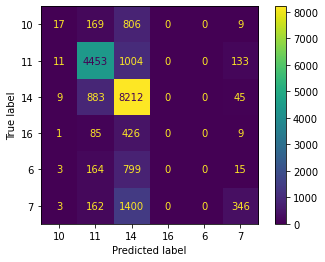

<Figure size 576x432 with 0 Axes>

val Loss: 0.7178 Acc: 0.7429
val Epoch Entropy: 1.1003
val Balanced Accuracy: 0.4167



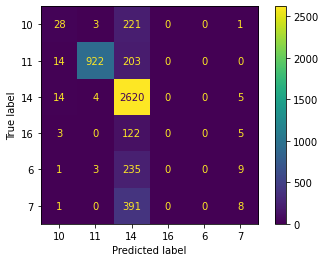

<Figure size 576x432 with 0 Axes>

Number of skipped: 1502

Epoch 1/39
----------
train Loss: 0.7066 Acc: 0.7286
train Epoch Entropy: 1.0735
train Balanced Accuracy: 0.6667



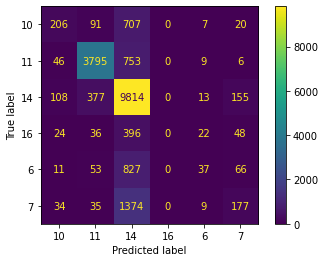

<Figure size 576x432 with 0 Axes>

val Loss: 0.6467 Acc: 0.7544
val Epoch Entropy: 1.0028
val Balanced Accuracy: 0.5500



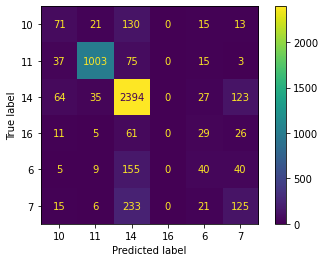

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 2/39
----------
train Loss: 0.6697 Acc: 0.7389
train Epoch Entropy: 1.0043
train Balanced Accuracy: 0.4722



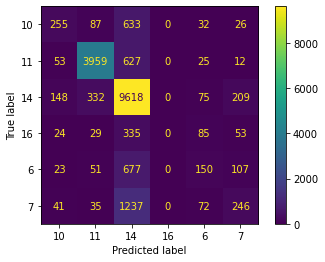

<Figure size 576x432 with 0 Axes>

val Loss: 0.6387 Acc: 0.7602
val Epoch Entropy: 0.9919
val Balanced Accuracy: 0.0000



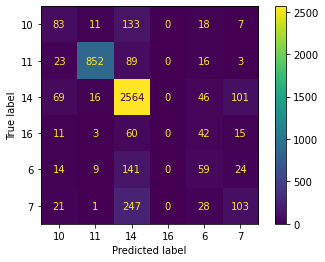

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 3/39
----------
train Loss: 0.6594 Acc: 0.7435
train Epoch Entropy: 0.9838
train Balanced Accuracy: 0.6000



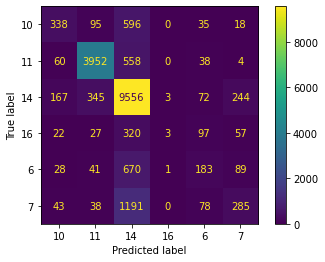

<Figure size 576x432 with 0 Axes>

val Loss: 0.6465 Acc: 0.7525
val Epoch Entropy: 0.9437
val Balanced Accuracy: 0.6667



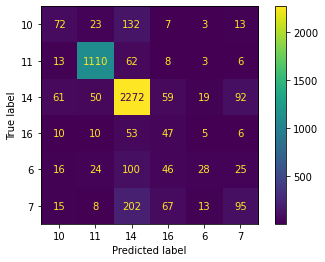

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 4/39
----------
train Loss: 0.6584 Acc: 0.7441
train Epoch Entropy: 0.9906
train Balanced Accuracy: 0.8750



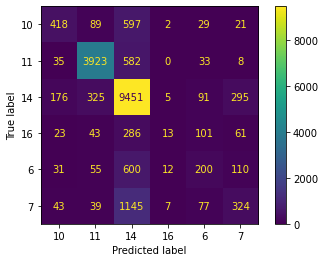

<Figure size 576x432 with 0 Axes>

val Loss: 0.6780 Acc: 0.7587
val Epoch Entropy: 0.9642
val Balanced Accuracy: 0.3000



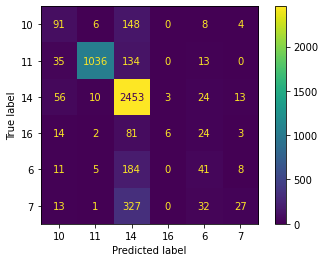

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 5/39
----------
train Loss: 0.6529 Acc: 0.7477
train Epoch Entropy: 0.9762
train Balanced Accuracy: 0.8333



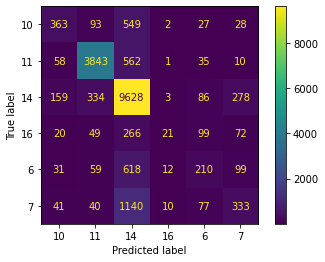

<Figure size 576x432 with 0 Axes>

val Loss: 0.6850 Acc: 0.7612
val Epoch Entropy: 0.9740
val Balanced Accuracy: 0.3750



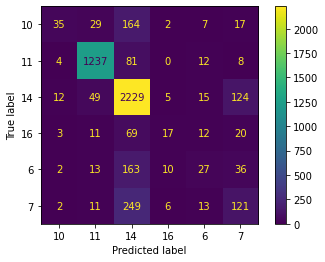

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 6/39
----------
train Loss: 0.6683 Acc: 0.7447
train Epoch Entropy: 1.0147
train Balanced Accuracy: 0.7000



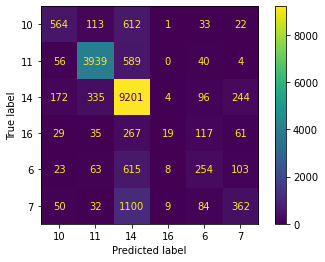

<Figure size 576x432 with 0 Axes>

val Loss: 0.6515 Acc: 0.7699
val Epoch Entropy: 0.9738
val Balanced Accuracy: 0.5000



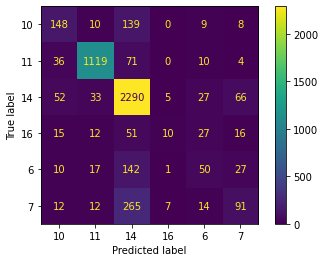

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 7/39
----------
train Loss: 0.6039 Acc: 0.7686
train Epoch Entropy: 0.9704
train Balanced Accuracy: 0.5000



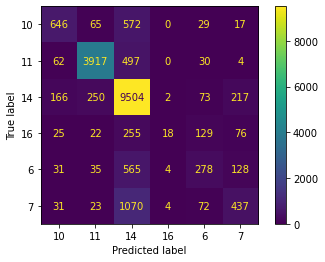

<Figure size 576x432 with 0 Axes>

val Loss: 0.6337 Acc: 0.7703
val Epoch Entropy: 0.9245
val Balanced Accuracy: 0.5111



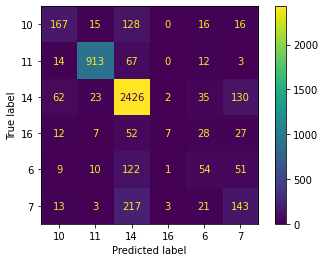

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 8/39
----------
train Loss: 0.5659 Acc: 0.7852
train Epoch Entropy: 0.9373
train Balanced Accuracy: 0.7500



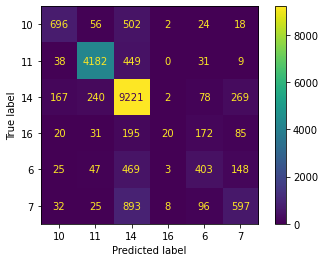

<Figure size 576x432 with 0 Axes>

val Loss: 0.6816 Acc: 0.7652
val Epoch Entropy: 0.8238
val Balanced Accuracy: 0.5926



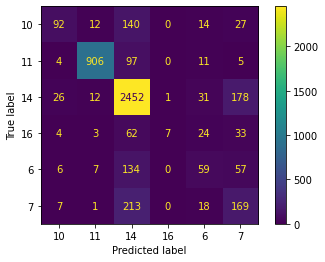

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 9/39
----------
train Loss: 0.5446 Acc: 0.7947
train Epoch Entropy: 0.9250
train Balanced Accuracy: 0.0000



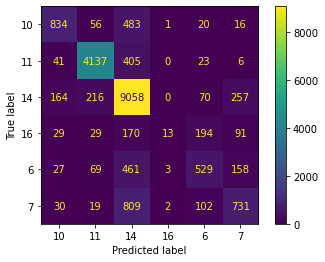

<Figure size 576x432 with 0 Axes>

val Loss: 0.6970 Acc: 0.7616
val Epoch Entropy: 0.8924
val Balanced Accuracy: 0.6000



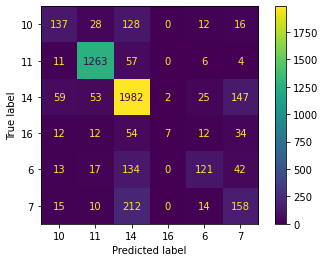

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 10/39
----------
train Loss: 0.5532 Acc: 0.7978
train Epoch Entropy: 0.9797
train Balanced Accuracy: 0.5333



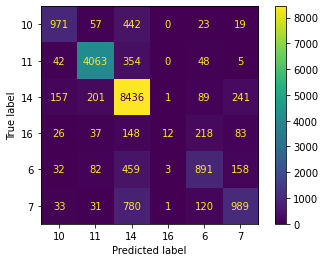

<Figure size 576x432 with 0 Axes>

val Loss: 0.7508 Acc: 0.7627
val Epoch Entropy: 0.9140
val Balanced Accuracy: 0.0000



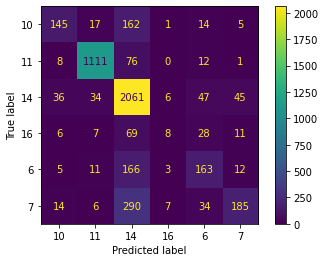

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 11/39
----------
train Loss: 0.5213 Acc: 0.8126
train Epoch Entropy: 0.9685
train Balanced Accuracy: 0.0000



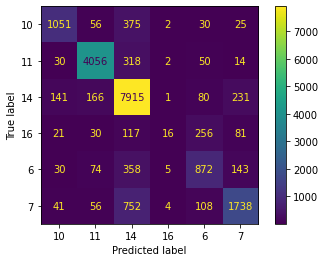

<Figure size 576x432 with 0 Axes>

val Loss: 0.7684 Acc: 0.7515
val Epoch Entropy: 0.9261
val Balanced Accuracy: 0.0000



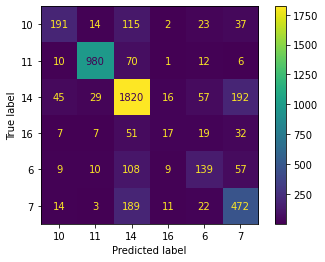

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 12/39
----------
train Loss: 0.5033 Acc: 0.8196
train Epoch Entropy: 0.9652
train Balanced Accuracy: 0.7500



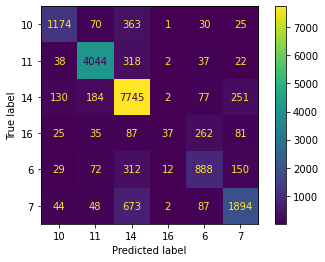

<Figure size 576x432 with 0 Axes>

val Loss: 0.8103 Acc: 0.7446
val Epoch Entropy: 0.9417
val Balanced Accuracy: 0.7000



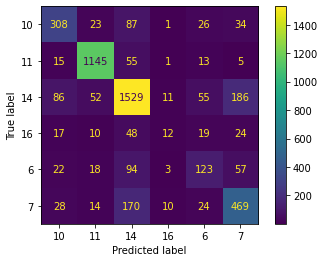

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 13/39
----------
train Loss: 0.4825 Acc: 0.8318
train Epoch Entropy: 0.9495
train Balanced Accuracy: 0.0000



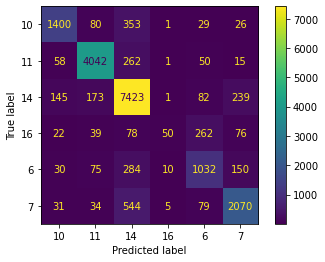

<Figure size 576x432 with 0 Axes>

val Loss: 0.8041 Acc: 0.7434
val Epoch Entropy: 0.9091
val Balanced Accuracy: 0.0000



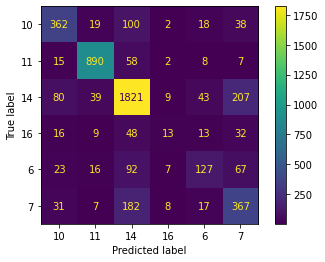

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 14/39
----------
train Loss: 0.4284 Acc: 0.8587
train Epoch Entropy: 0.9145
train Balanced Accuracy: 0.0000



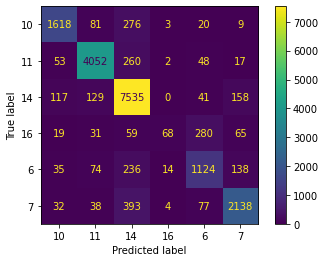

<Figure size 576x432 with 0 Axes>

val Loss: 0.8547 Acc: 0.7463
val Epoch Entropy: 0.8858
val Balanced Accuracy: 0.0000



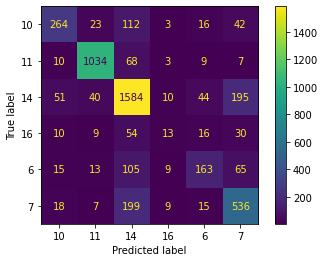

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 15/39
----------
train Loss: 0.4305 Acc: 0.8568
train Epoch Entropy: 0.9018
train Balanced Accuracy: 0.8667



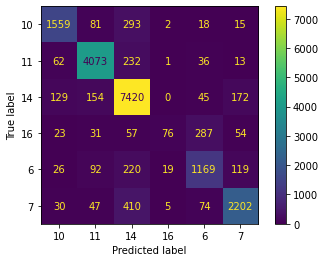

<Figure size 576x432 with 0 Axes>

val Loss: 0.8500 Acc: 0.7483
val Epoch Entropy: 0.8966
val Balanced Accuracy: 0.4792



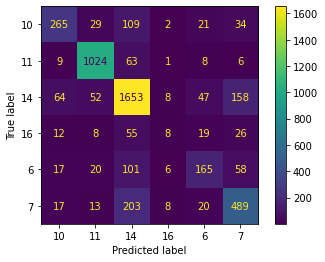

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 16/39
----------
train Loss: 0.4231 Acc: 0.8598
train Epoch Entropy: 0.9015
train Balanced Accuracy: 0.0000



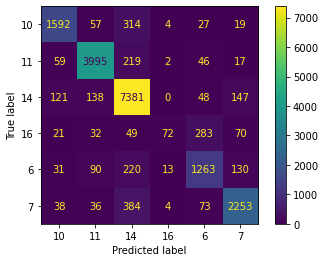

<Figure size 576x432 with 0 Axes>

val Loss: 0.8817 Acc: 0.7456
val Epoch Entropy: 0.8482
val Balanced Accuracy: 1.0000



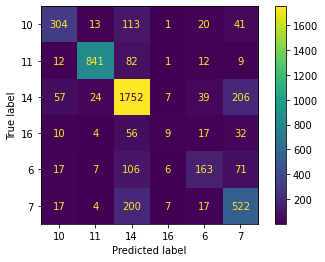

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 17/39
----------
train Loss: 0.4157 Acc: 0.8646
train Epoch Entropy: 0.8963
train Balanced Accuracy: 0.0000



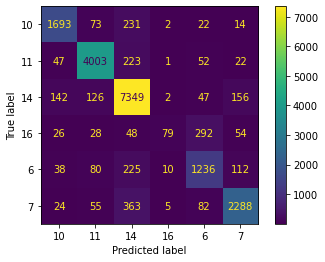

<Figure size 576x432 with 0 Axes>

val Loss: 0.8663 Acc: 0.7465
val Epoch Entropy: 0.9276
val Balanced Accuracy: 0.7429



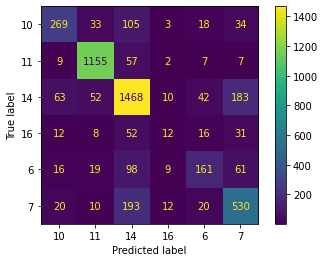

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 18/39
----------
train Loss: 0.4162 Acc: 0.8626
train Epoch Entropy: 0.8940
train Balanced Accuracy: 0.0000



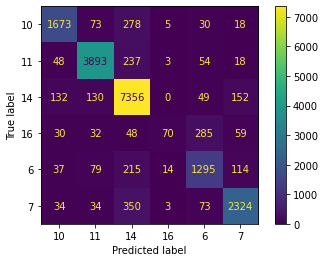

<Figure size 576x432 with 0 Axes>

val Loss: 0.8620 Acc: 0.7479
val Epoch Entropy: 0.9419
val Balanced Accuracy: 0.6667



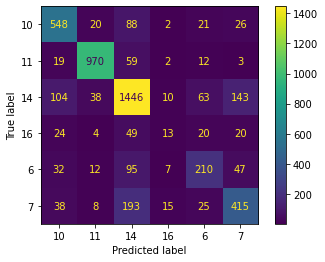

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 19/39
----------
train Loss: 0.4144 Acc: 0.8654
train Epoch Entropy: 0.8844
train Balanced Accuracy: 1.0000



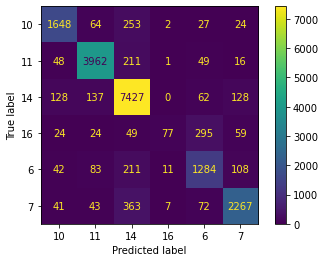

<Figure size 576x432 with 0 Axes>

val Loss: 0.8708 Acc: 0.7436
val Epoch Entropy: 0.9535
val Balanced Accuracy: 0.0000



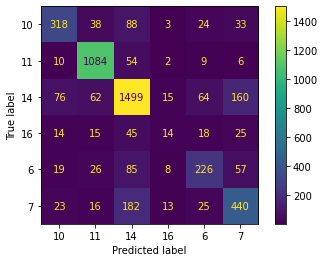

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 20/39
----------
train Loss: 0.4093 Acc: 0.8651
train Epoch Entropy: 0.8806
train Balanced Accuracy: 0.6250



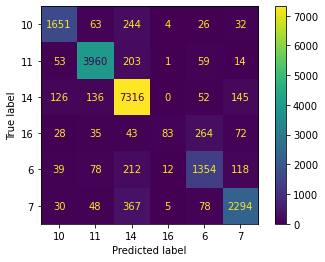

<Figure size 576x432 with 0 Axes>

val Loss: 0.8869 Acc: 0.7398
val Epoch Entropy: 0.9652
val Balanced Accuracy: 0.7667



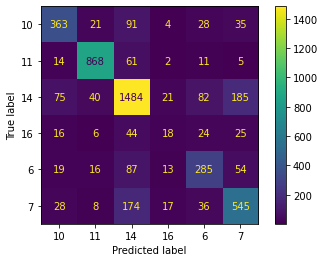

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 21/39
----------
train Loss: 0.4061 Acc: 0.8689
train Epoch Entropy: 0.8794
train Balanced Accuracy: 1.0000



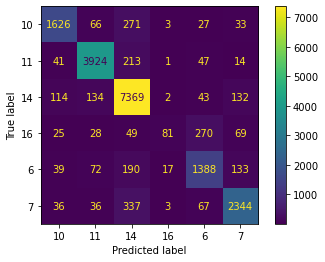

<Figure size 576x432 with 0 Axes>

val Loss: 0.8616 Acc: 0.7492
val Epoch Entropy: 0.9329
val Balanced Accuracy: 0.6083



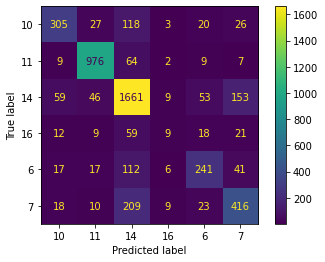

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 22/39
----------
train Loss: 0.4025 Acc: 0.8703
train Epoch Entropy: 0.8775
train Balanced Accuracy: 0.0000



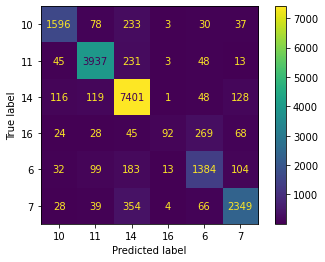

<Figure size 576x432 with 0 Axes>

val Loss: 0.9126 Acc: 0.7384
val Epoch Entropy: 0.8722
val Balanced Accuracy: 0.0000



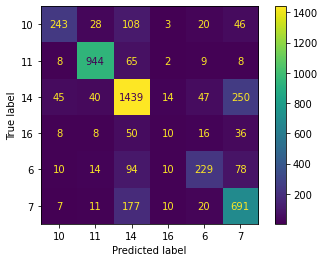

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 23/39
----------
train Loss: 0.4049 Acc: 0.8654
train Epoch Entropy: 0.8775
train Balanced Accuracy: 0.8000



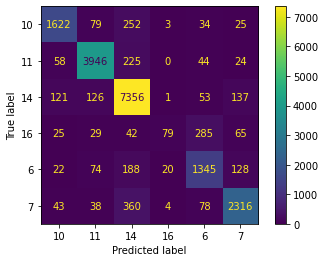

<Figure size 576x432 with 0 Axes>

val Loss: 0.8709 Acc: 0.7419
val Epoch Entropy: 0.9249
val Balanced Accuracy: 0.6714



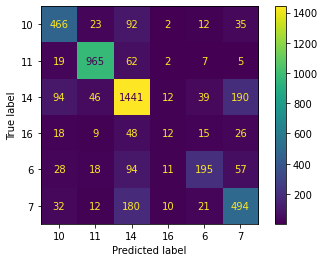

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 24/39
----------
train Loss: 0.4011 Acc: 0.8704
train Epoch Entropy: 0.8781
train Balanced Accuracy: 0.0000



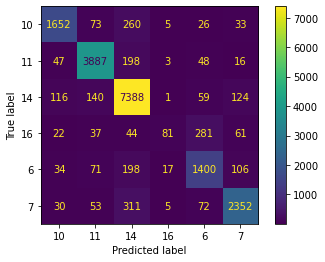

<Figure size 576x432 with 0 Axes>

val Loss: 0.8757 Acc: 0.7392
val Epoch Entropy: 0.9625
val Balanced Accuracy: 0.4929



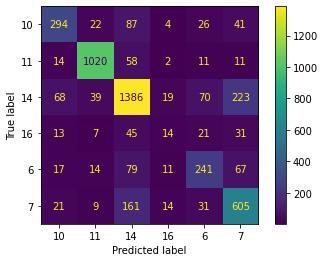

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 25/39
----------
train Loss: 0.4078 Acc: 0.8680
train Epoch Entropy: 0.8809
train Balanced Accuracy: 0.0000



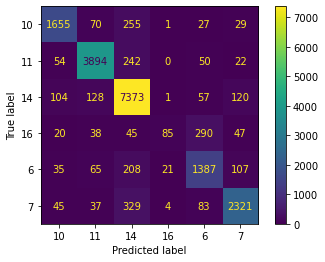

<Figure size 576x432 with 0 Axes>

val Loss: 0.9173 Acc: 0.7498
val Epoch Entropy: 0.8370
val Balanced Accuracy: 0.0000



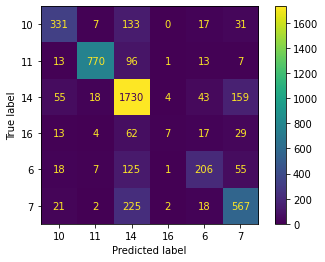

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 26/39
----------
train Loss: 0.4012 Acc: 0.8704
train Epoch Entropy: 0.8717
train Balanced Accuracy: 0.0000



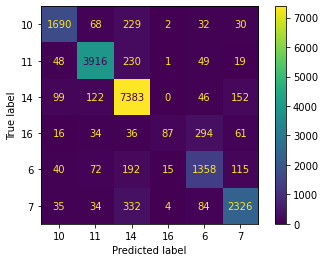

<Figure size 576x432 with 0 Axes>

val Loss: 0.8734 Acc: 0.7402
val Epoch Entropy: 0.9207
val Balanced Accuracy: 0.7000



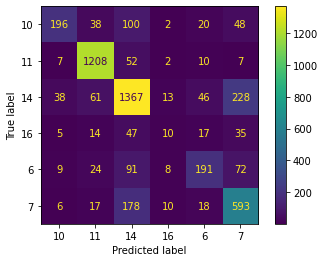

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 27/39
----------
train Loss: 0.4066 Acc: 0.8657
train Epoch Entropy: 0.8791
train Balanced Accuracy: 0.0000



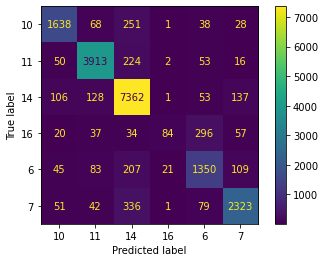

<Figure size 576x432 with 0 Axes>

val Loss: 0.8782 Acc: 0.7471
val Epoch Entropy: 0.8802
val Balanced Accuracy: 0.8958



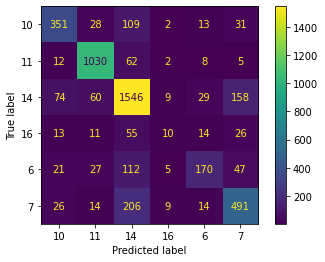

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 28/39
----------
train Loss: 0.4055 Acc: 0.8688
train Epoch Entropy: 0.8758
train Balanced Accuracy: 1.0000



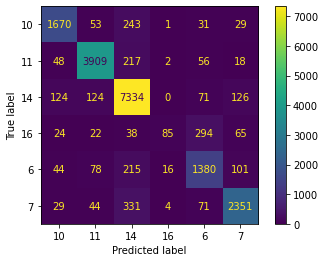

<Figure size 576x432 with 0 Axes>

val Loss: 0.8844 Acc: 0.7390
val Epoch Entropy: 1.0187
val Balanced Accuracy: 0.6867



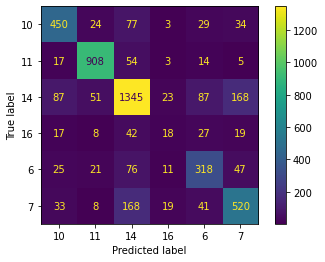

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 29/39
----------
train Loss: 0.4032 Acc: 0.8704
train Epoch Entropy: 0.8753
train Balanced Accuracy: 0.8750



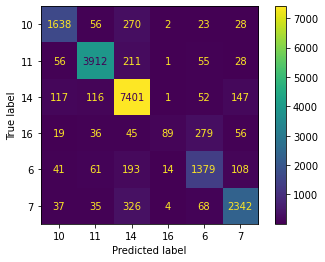

<Figure size 576x432 with 0 Axes>

val Loss: 0.9029 Acc: 0.7407
val Epoch Entropy: 0.9272
val Balanced Accuracy: 0.6375



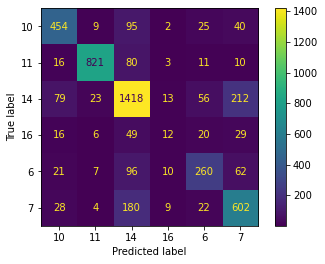

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 30/39
----------
train Loss: 0.4068 Acc: 0.8690
train Epoch Entropy: 0.8800
train Balanced Accuracy: 1.0000



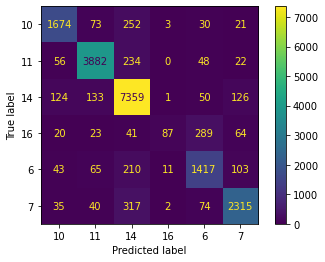

<Figure size 576x432 with 0 Axes>

val Loss: 0.8877 Acc: 0.7498
val Epoch Entropy: 0.8386
val Balanced Accuracy: 0.6600



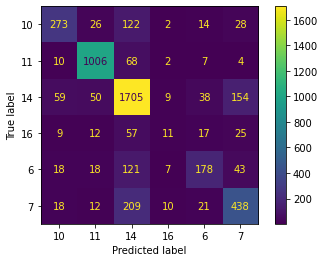

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 31/39
----------
train Loss: 0.4030 Acc: 0.8698
train Epoch Entropy: 0.8755
train Balanced Accuracy: 0.0000



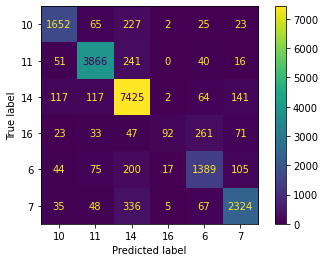

<Figure size 576x432 with 0 Axes>

val Loss: 0.8808 Acc: 0.7423
val Epoch Entropy: 0.9058
val Balanced Accuracy: 0.0000



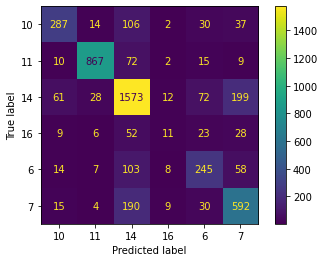

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 32/39
----------
train Loss: 0.4037 Acc: 0.8701
train Epoch Entropy: 0.8738
train Balanced Accuracy: 0.6000



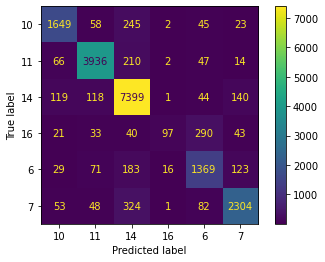

<Figure size 576x432 with 0 Axes>

val Loss: 0.8838 Acc: 0.7404
val Epoch Entropy: 0.8998
val Balanced Accuracy: 0.0000



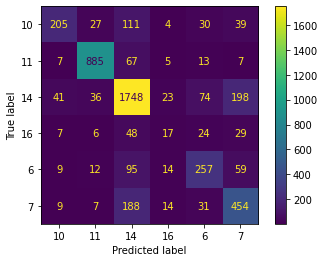

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 33/39
----------
train Loss: 0.3983 Acc: 0.8702
train Epoch Entropy: 0.8714
train Balanced Accuracy: 0.8000



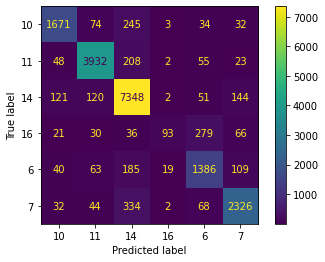

<Figure size 576x432 with 0 Axes>

val Loss: 0.8703 Acc: 0.7400
val Epoch Entropy: 0.9658
val Balanced Accuracy: 0.0000



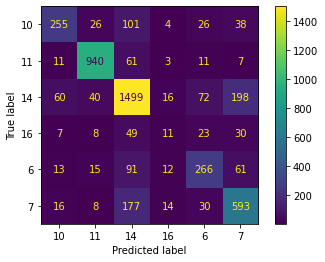

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 34/39
----------
train Loss: 0.3977 Acc: 0.8732
train Epoch Entropy: 0.8705
train Balanced Accuracy: 0.0000



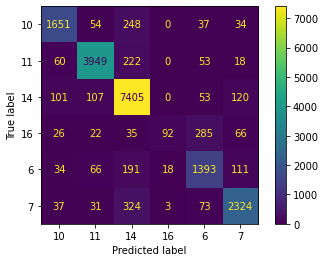

<Figure size 576x432 with 0 Axes>

val Loss: 0.8916 Acc: 0.7348
val Epoch Entropy: 0.9802
val Balanced Accuracy: 0.0000



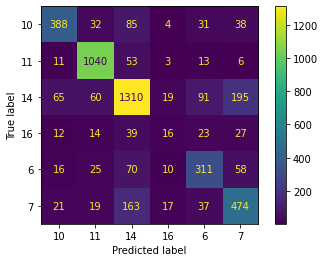

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 35/39
----------
train Loss: 0.4060 Acc: 0.8679
train Epoch Entropy: 0.8762
train Balanced Accuracy: 0.6667



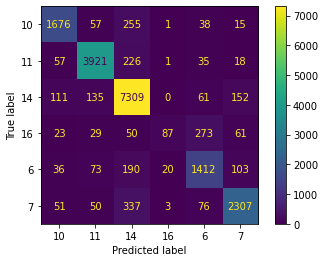

<Figure size 576x432 with 0 Axes>

val Loss: 0.8915 Acc: 0.7440
val Epoch Entropy: 0.9367
val Balanced Accuracy: 0.0000



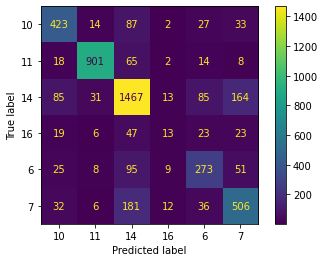

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 36/39
----------
train Loss: 0.4017 Acc: 0.8703
train Epoch Entropy: 0.8763
train Balanced Accuracy: 0.8125



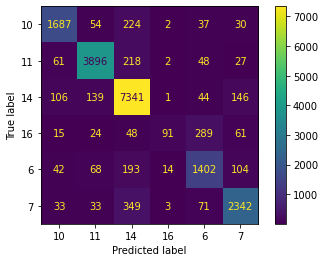

<Figure size 576x432 with 0 Axes>

val Loss: 0.8939 Acc: 0.7371
val Epoch Entropy: 0.9655
val Balanced Accuracy: 0.5556



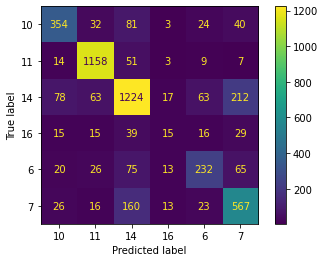

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 37/39
----------
train Loss: 0.4047 Acc: 0.8672
train Epoch Entropy: 0.8789
train Balanced Accuracy: 0.0000



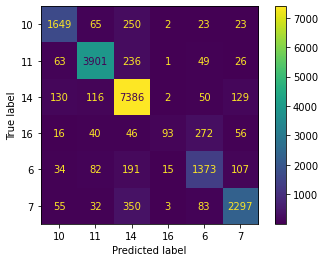

<Figure size 576x432 with 0 Axes>

val Loss: 0.8973 Acc: 0.7436
val Epoch Entropy: 0.8883
val Balanced Accuracy: 0.8393



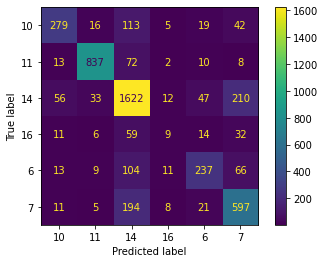

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 38/39
----------
train Loss: 0.4073 Acc: 0.8684
train Epoch Entropy: 0.8803
train Balanced Accuracy: 1.0000



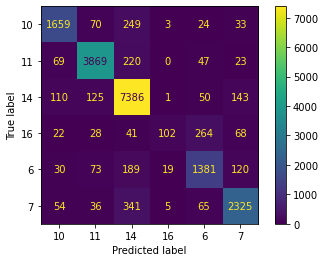

<Figure size 576x432 with 0 Axes>

val Loss: 0.8802 Acc: 0.7465
val Epoch Entropy: 0.8972
val Balanced Accuracy: 0.8250



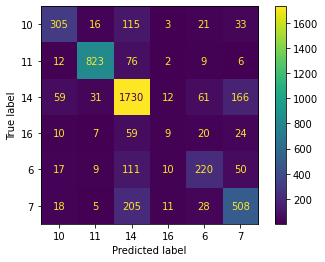

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Epoch 39/39
----------
train Loss: 0.3999 Acc: 0.8692
train Epoch Entropy: 0.8677
train Balanced Accuracy: 0.7500



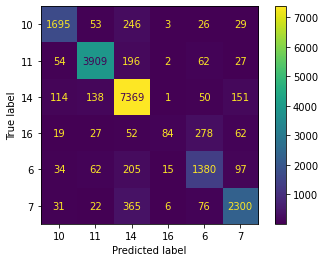

<Figure size 576x432 with 0 Axes>

val Loss: 0.9210 Acc: 0.7326
val Epoch Entropy: 0.9404
val Balanced Accuracy: 0.0000



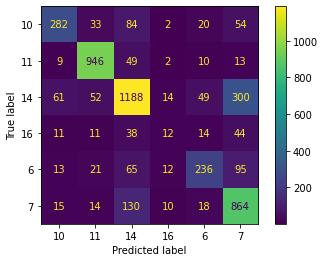

<Figure size 576x432 with 0 Axes>

Number of skipped: 1505

Training complete in 155m 2s
Best val Acc: 0.770349


In [25]:
model_list = []
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=wd)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset_strong, valset_strong,trainset_weak,valset_weak, model, criterion, optimizer, exp_lr_scheduler, num_epoch, bs,hardness_threshold)
    


The Test Accuracy: tensor(0.4637, device='cuda:0')
The Test Balanced Accuracy: 0.28273175264415806


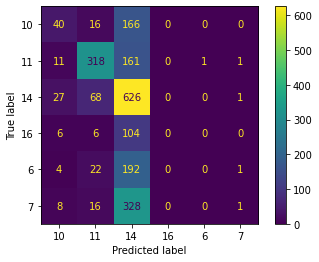

<Figure size 576x432 with 0 Axes>

In [33]:
test_model(model, testset_strong)


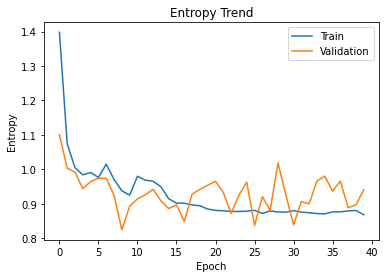

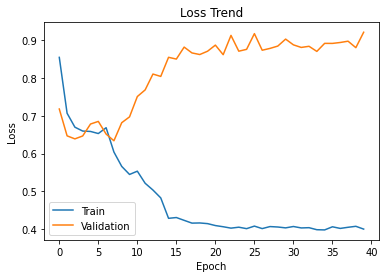

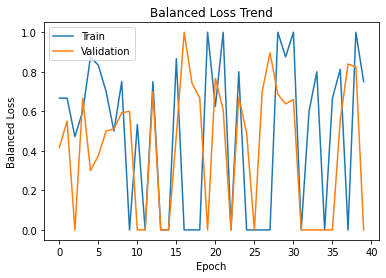

In [27]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [28]:
train_X, train_Y = weighted_score_array(model,model_list, trainset_strong, trainset_weak)
test_X, test_Y = weighted_score_array(model,model_list, testset_strong, testset_strong)


In [29]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.16760828625235405


Accuracy for SVM: 0.7262241054613936
Balanced Accuracy:0.35412885822105067


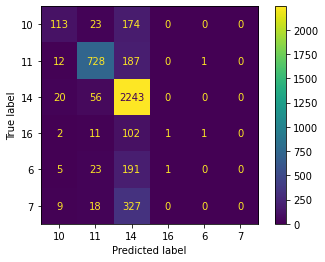

<Figure size 576x432 with 0 Axes>

In [30]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.727165725047081
Balanced Accuracy:0.3569977997966163


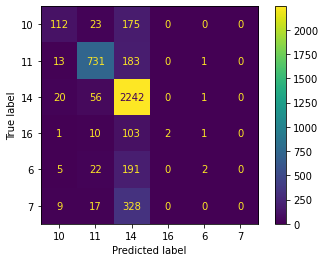

<Figure size 576x432 with 0 Axes>

In [31]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()